In [548]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

# Sometimes random selection of samples may lead to unbalanced classes in training and testing sets, and hence it's not necessarily optimal.
# Distribution of classification of labels in training and testing sets should be similar to that of the whole dataset.
# Stratified sampling ensures that each class is proportionally represented in both training and testing sets.
# This is particularly important in classification tasks where class imbalance can significantly affect model performance.

In [549]:
plt.style.use("ggplot")
np.random.seed(None)   # For reproducibility

In [550]:

# Dogs: higher ear flappiness index, lower whisker length
dogs_whisker_length = np.random.normal(loc=5, scale=1, size=10)
dogs_flappiness_index = np.random.normal(loc=8, scale=1, size=10)

In [551]:

# Cats: lower ear flappiness index, higher whisker length
cats_whisker_length = np.random.normal(loc=8, scale=1, size=10)
cats_flappiness_index = np.random.normal(loc=5, scale=1, size=10)

In [552]:
# Prepare data for algorithm: Although the row represents features and column represents samples, but we will transpose it later because sklearn expects samples in rows and features in columns. However, labels will be in a single row of shape (n_samples,),
data_dogs = np.vstack((dogs_whisker_length, dogs_flappiness_index)).T
data_cats = np.vstack((cats_whisker_length, cats_flappiness_index)).T

data = np.vstack((data_dogs, data_cats))

labels = np.hstack((np.zeros(np.shape(data_dogs)[0]), np.ones(np.shape(data_cats)[0])))

In [553]:
# Random split using sklearn.model_selection.train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)   # 42 is just a random seed for reproducibility

# Stratified split using sklearn.model_selection.StratifiedShuffleSplit
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in strat_split.split(data, labels):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

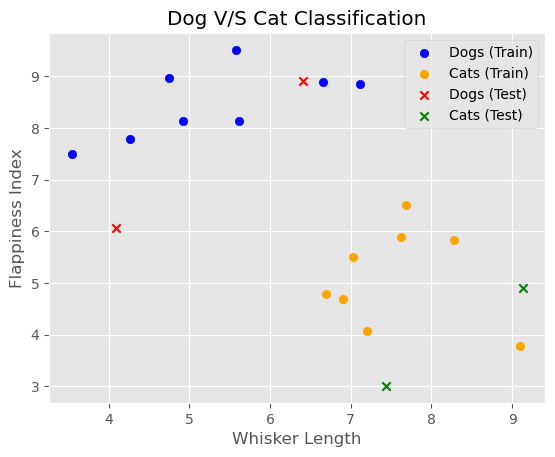

In [554]:
# Plotting the data points
# plt.scatter(dogs_whisker_length, dogs_flappiness_index, label="Dogs")
# plt.scatter(cats_whisker_length, cats_flappiness_index, label="Cats")
plt.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], label="Dogs (Train)", marker='o', color='blue')
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], label="Cats (Train)", marker='o', color='orange')
plt.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], label="Dogs (Test)", marker='x', color='red')
plt.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], label="Cats (Test)", marker='x', color='green')
plt.xlabel("Whisker Length")
plt.ylabel("Flappiness Index")
plt.title("Dog V/S Cat Classification")
plt.legend()

In [555]:
# Implementing the loss cost function for computing error
"""
Since this is supervised learning, we have the labels for the data points.
We can simply label dogs and cats with random variable y-hat as +1 and -1 respectively. (Or, maybe -1 and +1, which won't matter as its just a sign flip of labels).
We also know that dot product 
"""

def compute_error(data_dogs, data_cats, theta, theta0):
    error = 0
    # For dogs, y-hat = +1
    error = np.sum(np.sign(np.dot(theta, data_dogs) + theta0) > 0)
    # For cats, y-hat = -1
    error += np.sum(np.sign(np.dot(theta, data_cats) + theta0) < 0)
    return error

In [556]:
# Implementing Random Linear Classifier Algorithm

def random_linear_classifier(data_dogs, data_cats, k, d):
    """
    Random Linear Classifier Algorithm
    Args:
        data_dogs: Tuple of (whisker_length, flappiness_index) for dogs
        data_cats: Tuple of (whisker_length, flappiness_index) for cats
        k: Number of iterations to run
        d: number of features (2 in this case - whisker_length and flappiness_index)
    Returns:
        best_theta: Slope of the best line found
        best_theta0: Intercept of the best line found
    """
    best_error = float('inf')
    best_theta = None
    best_theta0 = None
    
    for _ in range(k):
        # Randomly generate theta and theta0 (picking a hypothesis from a hypothesis space|class)
        theta = np.random.normal(size=d)    # ideally it should be represented as transpose of d*1 vector. Then data_dogs and data_cats should be d*n matrix
        theta0 = np.random.normal()
        
        error = compute_error(data_dogs, data_cats, theta, theta0)
        
        if error < best_error:
            best_error = error
            best_theta = theta
            best_theta0 = theta0
    
    return best_theta, best_theta0

#### Up until now, we have measured the performance of the classifier, but haven't measured the performance of the algorithm itself. That is, the algo that we choose, is best or not?
#### This is done using CROSS-VALIDATION technique. We observe that as we increase value of "k", the error function reduces. Where do we need to stop increasing "k", so as to find the most optimal "k". Hence, we'll find such "k" for which the algorithm itself will perform best, i.e., finding the most optimal learning algorithm.

##### In this method, the split of original data is maintained, but the training data is itself get divided into some sets, (say 5), making "5-FOLD CROSS-VALIDATION".
##### In those 5 iterations, one training dataset section gets skipped in training the model, and then that skipped set is used for validation. That hypothesis' error is recorded, and later expected error is calculated, called CROSS-VALIDATION ERROR. Thus, we validated algo even without testing it on testing dataset yet. This is done for large number of "k", and "k" with lowest CVE value is picked, and hence its hypothesis.

In [557]:
# Define function for K-FOLD CROSS-VALIDATION
def cross_validate(X_train, y_train, k_values, d, n_splits=5):
    """
    Perform K-Fold Cross-Validation to evaluate the performance of the random linear classifier.
    
    Args:
        data_dogs: Tuple of (whisker_length, flappiness_index) for dogs
        data_cats: Tuple of (whisker_length, flappiness_index) for cats
        k_value: Number of iterations for the random linear classifier
        d: Number of features (2 in this case - whisker_length and flappiness_index)
        n_splits: Number of folds for cross-validation (default is 5)
    Returns:
        best_k: The value of k that gives the lowest average error across folds
    """
    
    kf = StratifiedKFold(n_splits, shuffle=True, random_state=42)
    avg_errors = []
    
    for k in k_values:
        errors = []
        
        for train_index, validation_index in kf.split(X_train, y_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            X_validation_fold = X_train[validation_index]
            y_validation_fold = y_train[validation_index]
            
            # Call linear classifier on training fold
            best_theta_fold, best_theta0_fold = random_linear_classifier(X_train_fold[y_train_fold == 0].T, X_train_fold[y_train_fold ==1].T,  k, d)
            # Compute error on validation fold
            errors.append(compute_error(X_validation_fold[y_validation_fold == 0].T, X_validation_fold[y_validation_fold == 1].T, best_theta_fold, best_theta0_fold))
        
        avg_errors.append(np.mean(errors))
    
    best_k = k_values[np.argmin(avg_errors)]
    return best_k


# Define k values to try (We don't know yet which one is best)
k_values = [1, 10, 50, 100, 200, 350, 500, 1000, 5000]

best_k = cross_validate(X_train, y_train, k_values, d=2)

print(f"Best value of k: {best_k}")

Best value of k: 50


In [558]:
# Run random linear classifier algorithm
# k = 1000  # Number of iterations - A hyperparameter
k = best_k
d = 2     # Number of features per data point
best_theta, best_theta0 = random_linear_classifier(data_dogs=np.transpose(X_train[y_train == 0]), data_cats=np.transpose(X_train[y_train == 1]), k=k, d=d)

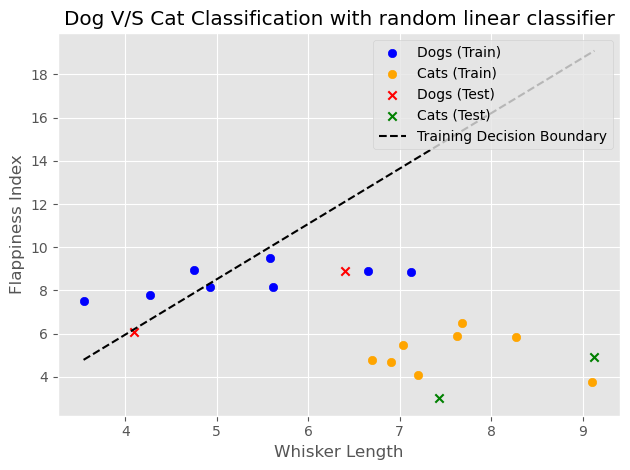

In [559]:
# Plotting the data points
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label="Dogs (Train)", marker="o", color="blue")
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label="Cats (Train)", marker="o", color="orange")
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], label="Dogs (Test)", marker="x", color="red")
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], label="Cats (Test)", marker="x", color="green")

# Plotting the decision boundary
X_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 200)
y_vals = -(best_theta0 + best_theta[0] * X_vals) / best_theta[1]  # Rearranging the equation of the line to get y in terms of x
plt.plot(X_vals, y_vals, label="Training Decision Boundary", color="black", linestyle="--")

plt.xlabel("Whisker Length")
plt.ylabel("Flappiness Index")
plt.title("Dog V/S Cat Classification with random linear classifier")
plt.legend(loc="upper right")

plt.tight_layout()

In [560]:
training_error = compute_error(X_train[y_train == 0].T, X_train[y_train == 1].T, best_theta, best_theta0)
testing_error = compute_error(X_test[y_test == 0].T, X_test[y_test == 1].T, best_theta, best_theta0)
print(f"Training Error: {training_error} out of {X_train.shape[0]} samples")
print(f"Testing Error: {testing_error} out of {X_test.shape[0]} samples")

Training Error: 5 out of 16 samples
Testing Error: 2 out of 4 samples


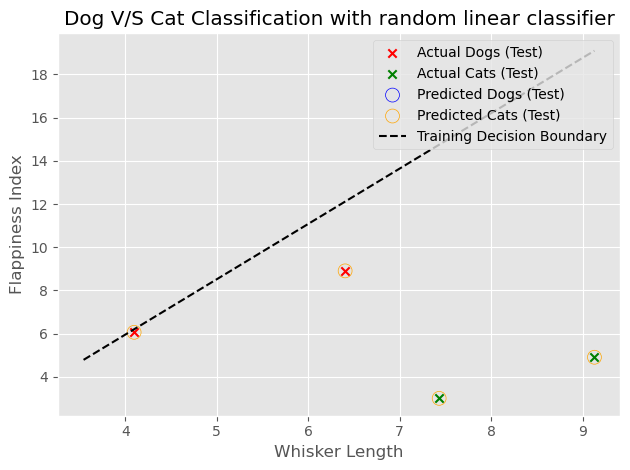

In [561]:
# Plot the actual test data and predicted test data
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], label="Actual Dogs (Test)", marker="x", color="red")
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], label="Actual Cats (Test)", marker="x", color="green")

# Predict test data points using the decision boundary
predicted_labels = np.empty_like(y_test)
for i, x_test in enumerate(X_test):
    if np.sign(np.dot(best_theta, x_test) + best_theta0) < 0:
        predicted_labels[i] = 0  # Dog
    else:
        predicted_labels[i] = 1  # Cat

# Plotting predicted test data points
plt.scatter(X_test[predicted_labels == 0][:, 0], X_test[predicted_labels == 0][:, 1], label="Predicted Dogs (Test)", marker="o", facecolors='none', edgecolors='blue', s=100)
plt.scatter(X_test[predicted_labels == 1][:, 0], X_test[predicted_labels == 1][:, 1], label="Predicted Cats (Test)", marker="o", facecolors='none', edgecolors='orange', s=100)

# Plot Decision Boundary
X_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 200)
y_vals = -(best_theta0 + best_theta[0] * X_vals) / best_theta[1]  # Rearranging the equation of the line to get y in terms of x
plt.plot(X_vals, y_vals, label="Training Decision Boundary", color="black", linestyle="--")

plt.xlabel("Whisker Length")
plt.ylabel("Flappiness Index")
plt.title("Dog V/S Cat Classification with random linear classifier")
plt.legend(loc="upper right")

plt.tight_layout()